illumspec shape (31,)
()
l max and min:  2115515.2206473453 ,  0.0
m max and min:  2196377.128846309 ,  0.0
s max and min:  1835127.7293907562 ,  0.0
l mean:  91.70042419433594
m mean:  87.86629104614258
s mean:  78.17840957641602
20494001
23033621
24038716


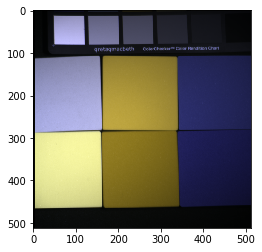

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import scipy.integrate
import skimage.color as sc

illum = np.loadtxt('./data/illuminant_D65.csv',delimiter=',')
illum = illum[20:81,:] #extracting 400-700 nm
illum = illum[::2] #extracting every alternate row (data was originally spaced by 5 nm)
illumSpec = illum[:,1] #just the spectral profile
print("illumspec shape", illumSpec.shape)


# illum = np.loadtxt('./data/illuminant_A.csv',delimiter=',')
# illum = illum[20:81,:] #extracting 400-700 nm
# illum = illum[::2] #extracting every alternate row (data was originally spaced by 5 nm)
# illumSpecA = illum[:,1] #just the spectral profile

def load_images_from_folder(folder):
    i = 0
    images = np.zeros((31,512,512,3)) 
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images[i]=img
            i+=1
    return images

pictures = load_images_from_folder('./data/sponges_ms') #get all images
images = pictures[:,:,:,1] #data is originally in duplicated triples

radiance = np.zeros((31,512,512)) 
count = 0
for i in range(512):
    for j in range(512):
        radiance[:,i,j] = np.multiply(images[:,i,j],illumSpec) #l = r*e (elementwise multiplication)




# radiance2 = np.zeros((31,512,512)) 
# count = 0
# for i in range(512):
#     for j in range(512):
#         radiance2[:,i,j] = np.multiply(images[:,i,j],illumSpecA) #l = r*e (elementwise multiplication)


sensitivity = np.loadtxt('./data/newerSens.csv',delimiter=',')
sensitivity = sensitivity[::2] #extracting 400-700 nm with 10 step.

#separating cone data
Lcone = sensitivity[:,1]
Mcone = sensitivity[:,2]
Scone = sensitivity[:,3]
X = sensitivity[:,0]

print(np.dot(radiance[:,3,3],Lcone.T).shape)

d = plt.plot(X, radiance[:,200,200])
# d2 = plt.plot(X, radiance2[:,200,200])

#making the L-cone component
lconeimg = np.zeros((512,512))
for i in range(512):
    for j in range(512):
#         lconeimg[i,j] = np.dot(radiance[:,i,j],Lcone.T)
        inside = np.multiply(radiance[:,i,j],Lcone) #s*l --> elementwise mult.
        lconeimg[i,j] = scipy.integrate.simps(inside, X) #integration
#         lconeimg[i,j] = np.sum(inside) #integration


        
#making the M-cone component
mconeimg = np.zeros((512,512))
for i in range(512):
    for j in range(512):
#         mconeimg[i,j] = np.dot(radiance[:,i,j],Mcone.T)
        inside = np.multiply(radiance[:,i,j],Mcone)
        mconeimg[i,j] = scipy.integrate.simps(inside, X)
#         mconeimg[i,j] = np.sum(inside) #integration



#making the S-cone component
sconeimg = np.zeros((512,512))
for i in range(512):
    for j in range(512):
#         sconeimg[i,j] = np.dot(radiance[:,i,j],Scone.T)
        inside = np.multiply(radiance[:,i,j],Scone)
        sconeimg[i,j] = scipy.integrate.simps(inside, X)
#         sconeimg[i,j] = np.sum(inside) #integration



print("l max and min: ", np.amax(lconeimg), ", ", np.amin(lconeimg))
print("m max and min: ", np.amax(mconeimg), ", ", np.amin(mconeimg))
print("s max and min: ", np.amax(sconeimg), ", ", np.amin(sconeimg))

#rescaling images to have 0-1 range
lconeimg/=np.amax(lconeimg)
mconeimg/=np.amax(mconeimg)
sconeimg/=np.amax(sconeimg)

lconeimg = np.uint8(lconeimg*255)
mconeimg = np.uint8(mconeimg*255)
sconeimg = np.uint8(sconeimg*255)

print("l mean: ", np.mean(lconeimg))
print("m mean: ", np.mean(mconeimg))
print("s mean: ", np.mean(sconeimg))

print(np.sum(sconeimg))
print(np.sum(mconeimg))
print(np.sum(lconeimg))

# merging RGB
img = cv2.merge((lconeimg, mconeimg, sconeimg))


updated = sc.xyz2rgb(img)
# img_real = cv2.imread("./data/sponges_RGB.bmp")
# a = plt.imshow("Real Image", img_real)
# b = plt.imshow("original constructerdf Image", img)
# c = plt.imshow("Constructed Image", updated)


# from PIL import Image
# import numpy as np

# rgbimg = Image.open(r'./data/rgb.bmp')
# split = Image.Image.split(rgbimg)
# r = split[0]
# g = split[1]
# b = split[2]

# r/=np.amax(r)
# g/=np.amax(g)
# b/=np.amax(b)

# r = np.uint8(r*255)
# g = np.uint8(g*255)
# b = np.uint8(b*255)

# print(np.sum(r))
# print(np.sum(g))
# print(np.sum(b))
# newimg = cv2.merge((b, g, r))
# cv2.imshow("Split Constructed Image", newimg)


# rgbArray = np.zeros((512,512,3), 'uint8')
# rgbArray[..., 0] = sconeimg
# rgbArray[..., 1] = mconeimg
# rgbArray[..., 2] = lconeimg
# newimg = Image.fromarray(rgbArray)
plt.imshow(img)
# plt.show()
plt.show();




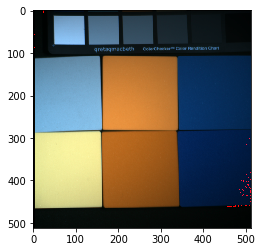

In [46]:
updated = np.zeros((512,512,3))    
#METHOD 0: 1934 curves from CIE
updated = img; #already using CIE RGB sensitivities
a = plt.imshow(updated)

#METHOD 1: SCIKIT INBUILT FUNCTION
updated = sc.xyz2rgb(img)
b = plt.imshow(updated)

#METHOD 2:
#Use conversion matrix, linked at MIT OCW:
#https://link.springer.com/content/pdf/10.1007%2F978-3-642-27851-8_323-1.pdf

XYZtoRGB = np.array([[2.768,1.751,1.130],
     [1,4.590,0.060],
     [0,0.056,5.594]])

for i in range(512):
    for j in range(512):
        updated[i,j,:] = np.dot(np.linalg.inv(XYZtoRGB),img[i,j,:])

updated[:,:,0]/=np.amax(updated[:,:,0])
updated[:,:,1]/=np.amax(updated[:,:,1])
updated[:,:,2]/=np.amax(updated[:,:,2])

updated=np.uint8(updated*255)
c = plt.imshow(updated)
plt.show();  




In [37]:
A=[[0.63,0.31,0.155],
 [0.34,0.595,0.07],
 [0.03,0.095, 0.775]]

def xyztorgb(li):
    xc=li[0]
    yc=li[1]
    zc=li[2]
    
    xr = 0.63
    xg = 0.31
    xb =0.155
    yr = 0.34
    yg = 0.595
    yb =0.07
    zr =  1 - (xr + yr);
    zg = 1 - (xg + yg);
    zb =1 - (xb + yb);
    xw = 0.3127
    yw = 0.3291
    zw = 1 - (xw + yw);


    rx = (yg * zb) - (yb * zg);  ry = (xb * zg) - (xg * zb);  rz = (xg * yb) - (xb * yg);
    gx = (yb * zr) - (yr * zb);  gy = (xr * zb) - (xb * zr);  gz = (xb * yr) - (xr * yb);
    bx = (yr * zg) - (yg * zr);  by = (xg * zr) - (xr * zg);  bz = (xr * yg) - (xg * yr);


    rw = ((rx * xw) + (ry * yw) + (rz * zw)) / yw;
    gw = ((gx * xw) + (gy * yw) + (gz * zw)) / yw;
    bw = ((bx * xw) + (by * yw) + (bz * zw)) / yw;

    rx = rx / rw;  ry = ry / rw;  rz = rz / rw;
    gx = gx / gw;  gy = gy / gw;  gz = gz / gw;
    bx = bx / bw;  by = by / bw;  bz = bz / bw;

    r = (rx * xc) + (ry * yc) + (rz * zc);
    g = (gx * xc) + (gy * yc) + (gz * zc);
    b = (bx * xc) + (by * yc) + (bz * zc);

    return([r,g,b])

for i in range(512):
    for j in range(512):
        updated[i,j,:] = xyztorgb(img[i,j,:])

updated[:,:,0]/=np.amax(updated[:,:,0])
updated[:,:,1]/=np.amax(updated[:,:,1])
updated[:,:,2]/=np.amax(updated[:,:,2])


c = plt.imshow(updated)
plt.show();   

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide